# Comparison of Structure Predictions Based on Data Format

In [1]:
import numpy as np
from diurnal import database, structure, train, utils, transform, visualize

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.

2024-05-28T21:19:20.827102 > INFO Download and install an RNA database.
2024-05-28T21:19:20.867282 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.


In [2]:
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-05-28T20:27:22.108231 > INFO Download and install an RNA database.
2024-05-28T20:27:22.143612 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-05-28T20:27:22.145706 > INFO Extract the filenames from the directory `./data/archiveII/`.
2024-05-28T20:27:49.344976 >    0 / 3975 [                                                  ] 16s_A.fulgidus.ct>    1 / 3975 [                                                  ] 16s_A.fulgidus_domain1.ct>    2 / 3975 [                                                  ] 16s_A.fulgidus_domain2.ct>    3 / 3975 [                                                  ] 16s_A.fulgidus_domain3.ct>    4 / 3975 [                                                  ] 16s_A.fulgidus_domain4.ct>    5 / 3975 [                                                  ] 16s_A.pyrophilus.ct>    6 / 3975 [                                                  ] 16s_A.pyrophilus_domain1.ct>    7 / 3975 [                                                  ] 16s_

In [3]:
def collapse(primary, secondary, size):
    potential_pairings = structure.Primary.to_matrix(
        primary, size, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    potential_pairings = transform.linearize_half_matrix(
        potential_pairings, len(primary), N=128**2
    )
    potential_pairings = transform.collapse_linearized_matrix(
        potential_pairings
    )
    contact = structure.Secondary.to_matrix(secondary)
    contact = transform.linearize_half_matrix(contact, len(primary))
    return potential_pairings, contact

In [4]:
_, primary, secondary = utils.rna_data.read_ct_file(train_names[0])
a, b = collapse(primary, secondary, 128)

In [5]:
originals = []
compressed = []
for name in train_names:
    _, primary, secondary = utils.rna_data.read_ct_file(name)
    originals.append(len(primary))
    a, b = collapse(primary, secondary, 128)
    compressed.append(len(a))

A = np.array(originals)
B = np.array(compressed)
print(f"Min: {A.min()}    {B.min()}")
print(f"Avr: {A.mean()}    {B.mean()}")
print(f"Max: {A.max()}    {B.max()}")
rate = B / (A**2 / 2)
print(f"Min: {rate.min()}")
print(f"Avr: {rate.mean()}")
print(f"Max: {rate.max()}")

Min: 28    180
Avr: 103.03387096774193    3217.9387096774194
Max: 128    5291
Min: 0.4
Avr: 0.5808142706761906
Max: 0.652985305970612


In [6]:
def format(dst: str, names: list[str]):
    # Primary structures
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_onehot.npy",
        SIZE, structure.Primary.to_matrix
    )
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    database.format_primary_structure(
        names, f"{dst}primary_linear.npy",
        SIZE, transform.primary_linear_formatter
    )
    database.format_primary_structure(
        names, f"{dst}primary_collapsed.npy",
        SIZE, transform.primary_linear_collapse_formatter
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_bracket.npy", SIZE,
        structure.Secondary.to_onehot
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )
    distance_formatter = lambda x, y: structure.Secondary.to_distance_matrix(
        x, y, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance.npy", SIZE, distance_formatter
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_linear.npy", SIZE,
        transform.secondary_linear_formatter
    )
    distance_formatter = lambda x, size: transform.secondary_linear_formatter(
        x, size, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_linear_distance.npy", SIZE,
        transform.secondary_linear_formatter
    )
    database.format_primary_secondary_structure(
        names, f"{dst}secondary_collapsed.npy", SIZE,
        transform.secondary_linear_collapse_formatter
    )
    distance_formatter = lambda x, y, size: transform.secondary_linear_collapse_formatter(
        x, y, size, power=5
    )
    database.format_primary_secondary_structure(
        names, f"{dst}secondary_collapsed_distance.npy", SIZE,
        distance_formatter
    )

In [7]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-05-28T20:28:09.297500 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy`.
2024-05-28T20:28:09.358452 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy` already contains the formatted data.
2024-05-28T20:28:09.360161 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-05-28T20:28:09.365942 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-05-28T20:28:09.367464 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-05-28T20:28:09.418158 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-05-28T20:28:09.421561 > INFO Formatting primary structures into `./data/archiveII_processed_128/

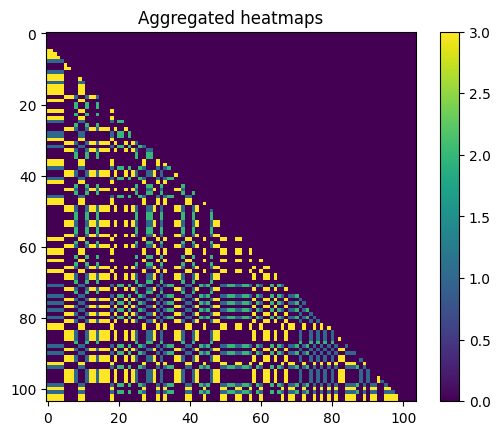

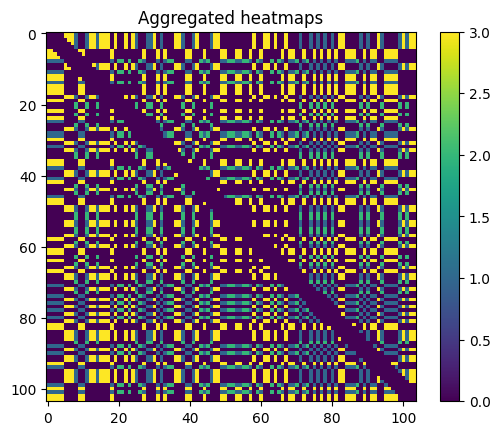

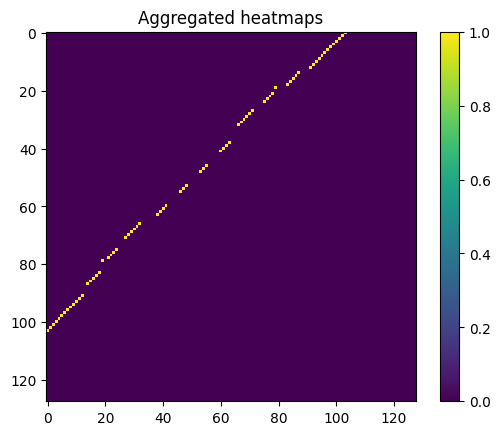

In [8]:
index = 0

primary = np.load(f"{DST}train/primary_onehot.npy")
sequence = structure.Primary.to_sequence(primary[index])
original_length = len(sequence)
collapsed_primary = np.load(f"{DST}train/primary_collapsed.npy")
potential_pairings = transform.decollapse_linearized_matrix(
    collapsed_primary[index], N_output=128**2
)
potential_pairings = transform.delinearize_half_matrix(potential_pairings, original_length)
visualize.heatmap(potential_pairings)

probe = structure.Primary.to_matrix(sequence, map=structure.Schemes.IUPAC_PAIRINGS_SCALARS)
visualize.heatmap(probe)

secondary = np.load(f"{DST}train/secondary_contact.npy")
contact = secondary[index]
visualize.heatmap(contact)

## Distance Training

In [3]:
def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "contact": np.load(f"{DST}train/secondary_contact.npy"),
        "sequence": np.load(f"{DST}train/primary_onehot.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "contact": np.load(f"{DST}validation/secondary_contact.npy"),
        "sequence": np.load(f"{DST}validation/primary_onehot.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "contact": np.load(f"{DST}test/secondary_contact.npy"),
        "sequence": np.load(f"{DST}test/primary_onehot.npy"),
        "names": []
    }
    return train_set, validation_set, test_set

t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_distance"
)

In [10]:
from diurnal.models import deep
from diurnal.models.deep import cnn
from torch import optim, nn

N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.Autoencoder2D,
    N=SIZE,
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-05-28T20:28:21.927666 > INFO Training the model with 1860 data points.
2024-05-28T20:28:21.929417 >     Using 232 data points for validation.
2024-05-28T20:28:21.929811 >     Beginning the training.
2024-05-28T20:28:27.612398 >   0 / 500 [                                                  ] Loss: 0.07757  Patience: 5
2024-05-28T20:28:28.108230 >   1 / 500 [                                                  ] Loss: 0.03679  Patience: 5
2024-05-28T20:28:28.598331 >   2 / 500 [                                                  ] Loss: 0.03320  Patience: 5
2024-05-28T20:28:29.088122 >   3 / 500 [                                                  ] Loss: 0.03126  Patience: 5
2024-05-28T20:28:29.574051 >   4 / 500 [                                                  ] Loss: 0.02769  Patience: 5
2024-05-28T20:28:30.057512 >   5 / 500 [                                                  ] Loss: 0.02331  Patience: 5
2024-05-28T20:28:30.537962 >   6 / 500 [                                          

In [11]:
index = 0
prediction = model.predict([tt["input"][0][index]])
distance = tt["output"][index]
true = tt["contact"][index]
sequence = tt["sequence"][index]

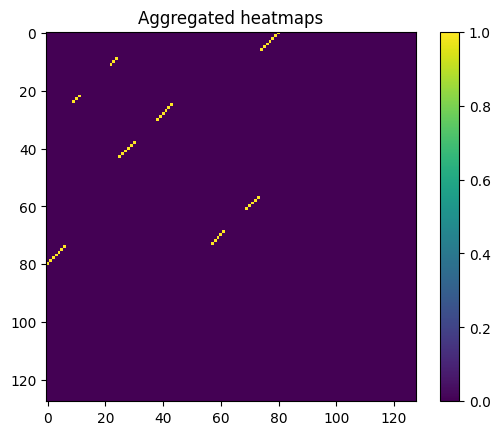

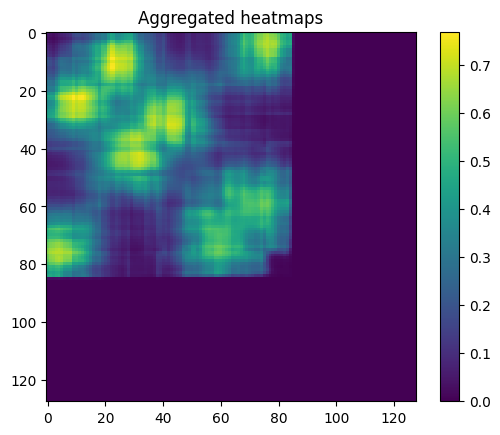

In [12]:
visualize.heatmap(true)
folded = prediction * prediction.T
visualize.heatmap(folded)

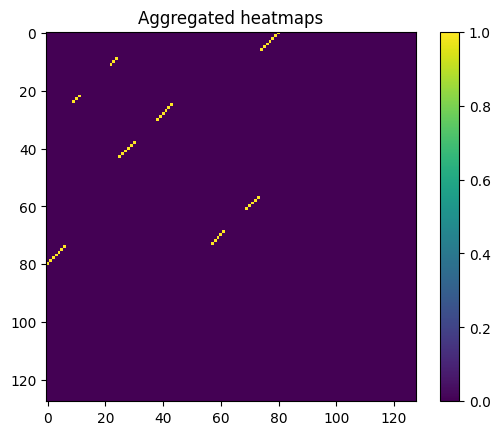

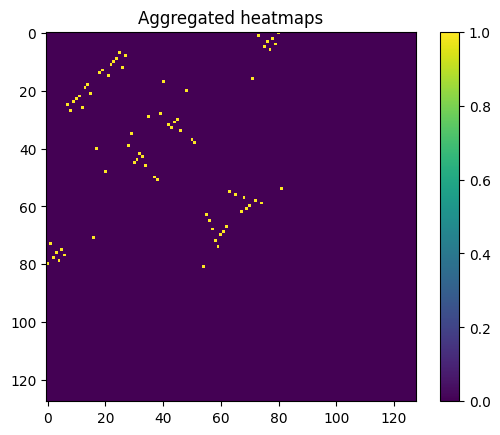

In [13]:
def quantize(matrix):
    matrix = matrix * matrix.T
    matrix = transform.to_monomial_matrix(matrix)
    matrix = transform.to_binary_matrix(matrix)
    return matrix

visualize.heatmap(true)
primary = structure.Primary.to_sequence(sequence)
mask = structure.Primary.to_mask(primary, size=128)
visualize.heatmap(quantize(prediction * mask))

## Contact Training

In [4]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_contact"
)

In [15]:
N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.Autoencoder2D,
    N=SIZE,
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-05-28T20:31:29.929511 > INFO Training the model with 1860 data points.
2024-05-28T20:31:29.935305 >     Using 232 data points for validation.
2024-05-28T20:31:29.938023 >     Beginning the training.


2024-05-28T20:31:30.767730 >   0 / 500 [                                                  ] Loss: 0.00357  Patience: 5
2024-05-28T20:31:31.267578 >   1 / 500 [                                                  ] Loss: 0.00357  Patience: 5
2024-05-28T20:31:31.749934 >   2 / 500 [                                                  ] Loss: 0.00357  Patience: 4
2024-05-28T20:31:32.234030 >   3 / 500 [                                                  ] Loss: 0.00357  Patience: 3
2024-05-28T20:31:32.742673 >   4 / 500 [                                                  ] Loss: 0.00357  Patience: 2
2024-05-28T20:31:33.247283 >   5 / 500 [                                                  ] Loss: 0.00357  Patience: 1



## Linear Distances Training

In [29]:
t, v, tt = format_data(
    "primary_linear",
    "secondary_linear_distance"
)

In [40]:
N_MAX_EPOCHS = 500

from torch import Tensor, stack, squeeze, nn, optim
from diurnal.models import deep
import torch.nn.functional as F

class Autoencoder1D(nn.Module):
    """Neural network used to predict a contact matrix.

    Input: 1D matrix.

    Output: 1D matrix with elements comprised within the range (0, 1).
    """
    def __init__(self, n: int):
        super().__init__()
        kernel = 3
        n2 = int(n / 2)
        n4 = int(n / 4)
        self.activation = F.relu
        self.linear1 = nn.Linear(n, n2)
        self.linear2 = nn.Linear(n2, n4)
        self.linear3 = nn.Linear(n4, n2)
        self.linear4 = nn.Linear(n4, n)
        self.output = nn.Sigmoid()

    def forward(self, y: Tensor) -> Tensor:
        """Forward propagation.

        Args:
            x: Potential pairing matrix.

        Returns: Blurry distance matrix.
        """
        x1 = stack((y, ), dim=1)
        x = self.activation(x1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        # x = self.linear3(x)
        # x = self.activation(x)
        x = self.linear4(x)
        x *= x1
        x = self.output(x)
        x = squeeze(x)
        return x

model = deep.NN(
    model=Autoencoder1D,
    N=int(SIZE**2/2),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-05-28T21:58:36.549483 > INFO Training the model with 1860 data points.
2024-05-28T21:58:36.549988 >     Using 232 data points for validation.
2024-05-28T21:58:36.549988 >     Beginning the training.
2024-05-28T21:58:37.932985 >   0 / 500 [                                                  ] Loss: 0.18800  Patience: 5
2024-05-28T21:58:39.053019 >   1 / 500 [                                                  ] Loss: 0.18797  Patience: 5
2024-05-28T21:58:40.218334 >   2 / 500 [                                                  ] Loss: 0.18796  Patience: 5
2024-05-28T21:58:41.343119 >   3 / 500 [                                                  ] Loss: 0.18793  Patience: 5
2024-05-28T21:58:42.494090 >   4 / 500 [                                                  ] Loss: 0.18793  Patience: 4
2024-05-28T21:58:43.625471 >   5 / 500 [                                                  ] Loss: 0.18792  Patience: 4
2024-05-28T21:58:44.793666 >   6 / 500 [                                          

In [41]:
from torch import tensor
index = 0
prediction = model.nn(tensor([tt["input"][0][index]]).to("cuda").half()).detach().cpu().numpy()
distance = tt["output"][index]
true = tt["contact"][index]
sequence = tt["sequence"][index]

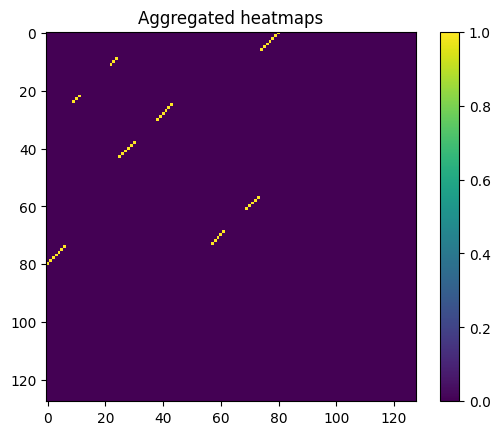

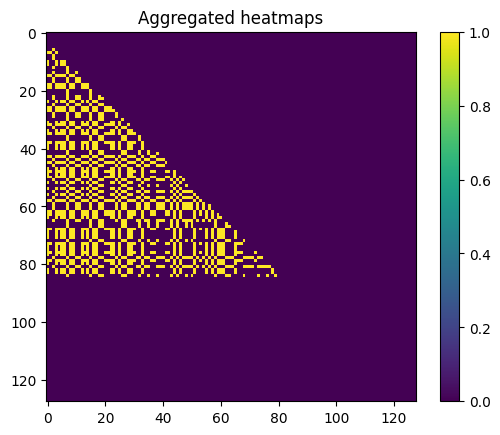

In [42]:
visualize.heatmap(true)
primary = structure.Primary.to_sequence(sequence)
half = transform.delinearize_half_matrix(prediction, len(primary), 128)
visualize.heatmap(half)